# RAG PDF Processing with Flotorch Gateway Monitoring

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FloTorch/Resources/blob/main/examples/flotorch-rag-notebooks/faiss-example/02_Gemini_RAG_Client_with_FAISS.ipynb)

This notebook demonstrates a complete RAG (Retrieval-Augmented Generation) pipeline for PDF documents with **Flotorch monitoring** using:
- **PyPDF2** for PDF text extraction
- **Sentence Transformers** for text embeddings
- **FAISS** for vector similarity search
- **Flotorch SDK** for monitored LLM calls to Google Gemini

## Key Benefits of Flotorch Integration:
- 🔍 **API Monitoring**: Track token usage, response times, and costs
- 📊 **Analytics Dashboard**: View usage patterns and performance metrics
- 🛡️ **Gateway Protection**: Rate limiting, security, and error handling
- 💰 **Cost Tracking**: Monitor LLM API spending across different models

## Key Benefits of Flotorch Integration:
- Step 1: Install Required Packages
- Step 2: Import the Libraries
- Step 3: Setup your API Keys
- Step 4: Upload Your PDF file
- Step 5: Split text into sentences
- Step 6: Load Embedding Model
- Step 7: Create FAISS Vector Index
- Step 8: Questions Generation with FloTorch Monitoring
- Step 9: RAG Search and Answer Generation with Monitoring

## Step 1: Install Required Packages

In [1]:
!pip install PyPDF2 sentence-transformers python-dotenv faiss-cpu requests numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.7 MB/s eta 0:00:00


## Step 2: Import Libraries and Setup

In [4]:
!pip install --pre flotorch[sdk]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 724.2 kB/s eta 0:00:00


In [7]:
# Mount Google Drive and set path
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

# Navigate to your notebook directory
os.chdir('/content/drive/MyDrive/Colab Notebooks')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
%mkdir -p FloTorch
%cd FloTorch
!git clone https://github.com/FloTorch/Resources.git
os.chdir("/content/drive/MyDrive/Colab Notebooks/FloTorch/Resources/examples/flotorch-rag-notebooks/faiss-example")
%ls
!pip install flotorch[all]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/FloTorch
fatal: destination path 'Resources' already exists and is not an empty directory.
01_Prerequisites.ipynb


In [ ]:
import os
import random
import time
import json
import sys
import requests
from typing import List
import tempfile

import PyPDF2
from sentence_transformers import SentenceTransformer
import faiss
from flotorch.sdk.llm import FlotorchLLM
from utils import extract_text_from_pdf, split_text_into_sentences, create_faiss_index, call_flotorch_api, generate_questions_from_pdf, perform_monitored_rag_search

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


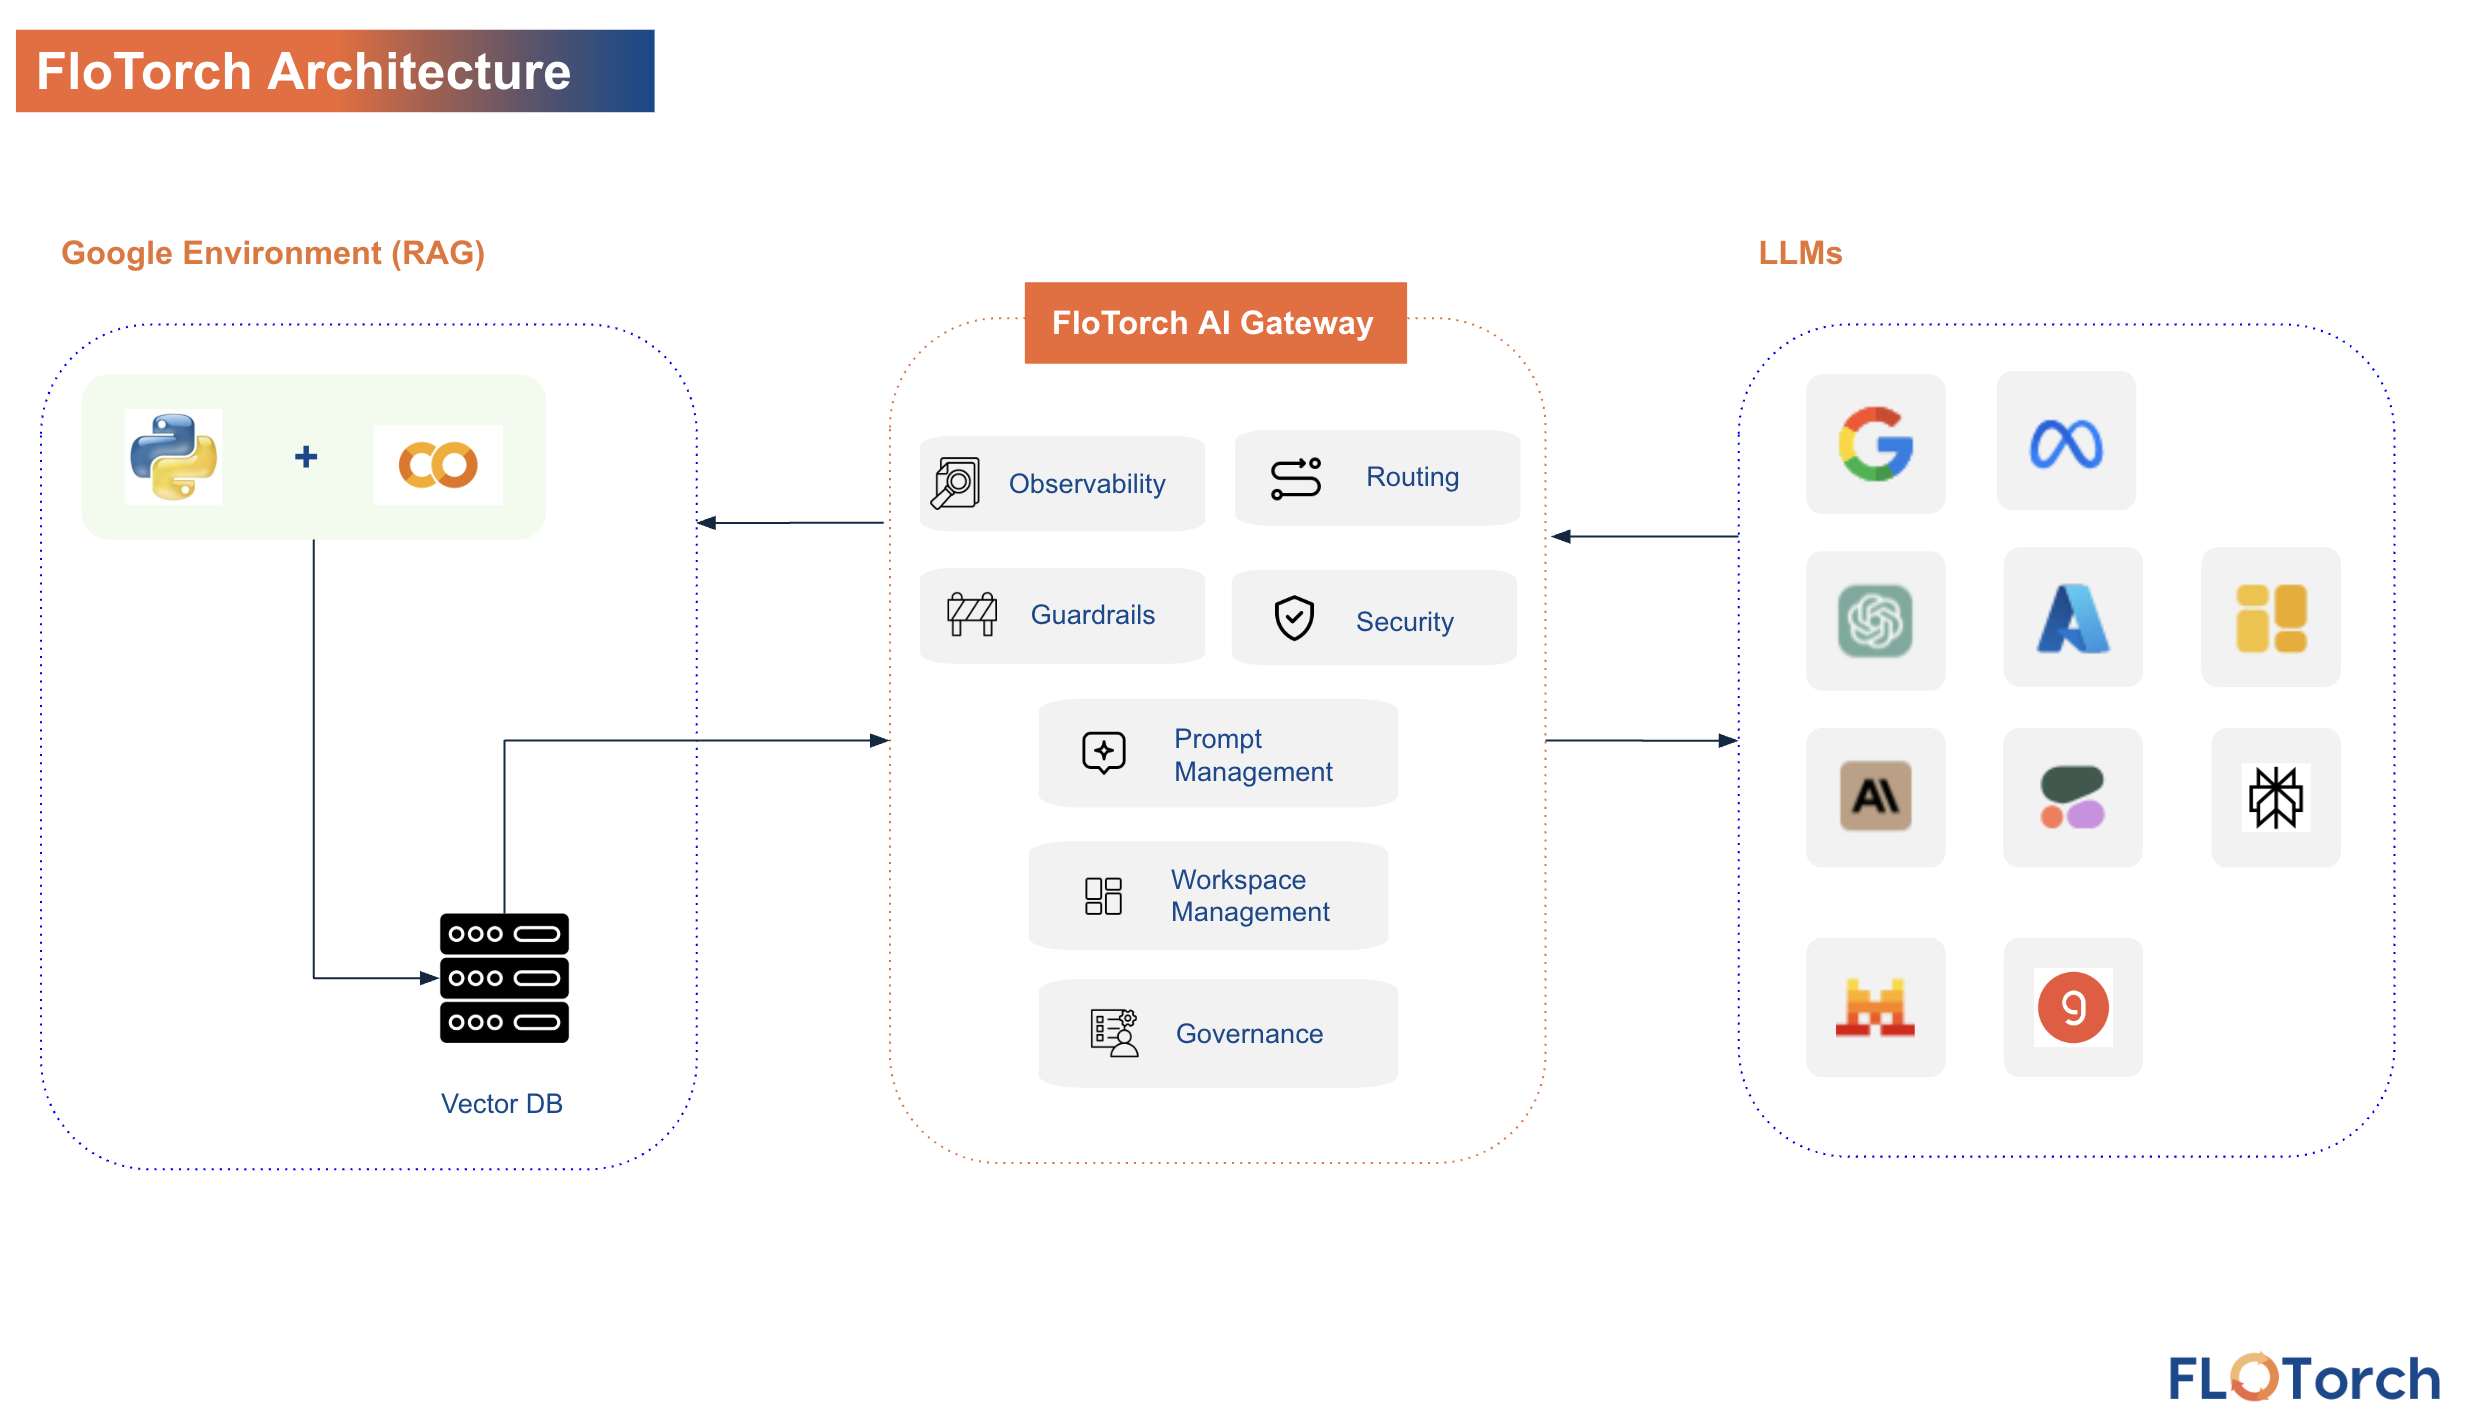

## Step 3: Set Your API Keys

**Important:**
- Replace with your actual Flotorch API key
- Flotorch acts as a gateway to monitor your Google Gemini usage

In [ ]:
# Set your Flotorch API key here
FLOTORCH_API_KEY = 'Flotorch Key'  # Replace with your actual Flotorch API key

# Flotorch configuration
FLOTORCH_ENDPOINT = "https://gateway.flotorch.cloud"
FLOTORCH_MODEL = "flotorch/model9"  # Your Flotorch model endpoint

# Verify API key is set
if FLOTORCH_API_KEY == 'your_flotorch_api_key_here':
    print("⚠️  Please replace 'your_flotorch_api_key_here' with your actual Flotorch API key")
else:
    print("✅ Flotorch API key configured successfully")
    print(f"🌐 Using endpoint: {FLOTORCH_ENDPOINT}")
    print(f"🤖 Using model: {FLOTORCH_MODEL}")

def call_flotorch_api(base_url: str, model_name: str, api_key: str, prompt: str) -> tuple:
    """Call Flotorch-monitored LLM API and return response with metadata."""
    messages = [{"role": "user", "content": prompt}]
    model = FlotorchLLM(model_id=model_name, api_key=api_key, base_url=base_url)

    try:
        print(f"🔄 Calling Flotorch API...")
        response = model.invoke(messages)
        generated_text = response.content

        # Extract metadata for monitoring
        tokens_used = response.metadata.get('totalTokens', 'N/A')

        print(f"📊 Tokens used: {tokens_used}")
        print(f"✅ Response received successfully")

        return generated_text, tokens_used

    except Exception as e:
        print(f"❌ API Error: {e}")
        return "", 0

✅ Flotorch API key configured successfully
🌐 Using endpoint: https://gateway.flotorch.cloud
🤖 Using model: flotorch/model9


## Step 4: Upload Your PDF File

In [ ]:
from google.colab import files

pdf_url = input("🔗 PDF URL: ")
temp_pdf = tempfile.mktemp('.pdf')
open(temp_pdf, 'wb').write(requests.get(pdf_url).content)

Please select your PDF file to upload:


Saving 3M_2015_10K.pdf to 3M_2015_10K (1).pdf

✅ Uploaded file: 3M_2015_10K (1).pdf


## Step 5: Define Helper Functions with Flotorch Integration

## Step 6: Extract Text from PDF

In [ ]:
print("🔄 Extracting text from PDF...")
text_content = extract_text_from_pdf(temp_pdf)
os.remove(temp_pdf)
print(f"✅ {len(text_content)} chars:", text_content[:200])

if not text_content.strip():
    print("❌ Error: No text content extracted from PDF.")
else:
    print(f"✅ Successfully extracted {len(text_content)} characters from PDF")
    print("\n📄 First 300 characters of extracted text:")
    print("-" * 50)
    print(text_content[:300] + "...")

🔄 Extracting text from PDF...
Successfully loaded PDF: 3M_2015_10K (1).pdf
Total pages: 158
Extracted text length: 607568 characters
✅ Successfully extracted 607568 characters from PDF

📄 First 300 characters of extracted text:
--------------------------------------------------
Table of Contents
 
 
low
 
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
 
FORM 10-K
 
☒
   ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE
SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended 
December 31, 2015
 
Commission file number 1-3285
 
3M 
COMPANY
State...


## Step 7: Split Text into Sentences

In [15]:
print("🔄 Splitting text into sentences...")
sentences = split_text_into_sentences(text_content)

if len(sentences) == 0:
    print("❌ Error: No sentences extracted from text.")
else:
    print(f"✅ Successfully extracted {len(sentences)} sentences")
    print("\n📝 Sample sentences:")
    print("-" * 50)
    for i, sentence in enumerate(sentences[:3]):
        print(f"{i+1}. {sentence}")
    if len(sentences) > 3:
        print(f"... and {len(sentences)-3} more sentences")

🔄 Splitting text into sentences...
Extracted 2648 sentences from PDF
✅ Successfully extracted 2648 sentences

📝 Sample sentences:
--------------------------------------------------
1. Table of Contents     low   UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C.
2. 20549   FORM 10-K   ☒    ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended  December 31, 2015   Commission file number 1-3285   3M  COMPANY State of Incorporation:  Delaware   I.R.S.
3. 41-0417775 Principal executive offices:  3M Center, St.
... and 2645 more sentences


## Step 8: Initialize Sentence Transformer Model

In [16]:
print("🔄 Loading sentence transformer model...")
MODEL_NAME = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(MODEL_NAME)
print(f"✅ Successfully loaded {MODEL_NAME} model")

🔄 Loading sentence transformer model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Successfully loaded all-MiniLM-L6-v2 model


## Step 9: Create FAISS Vector Index

In [17]:
print("🔄 Creating FAISS vector index...")
index, embeddings = create_faiss_index(sentences, embedder)
print("✅ FAISS index created successfully!")

🔄 Creating FAISS vector index...
Generating embeddings for sentences...
Embeddings shape: (2648, 384)
Using IVF8,PQ2x8 for larger dataset
Training index...
Adding vectors to index...
Index is trained: True
Number of vectors in index: 2648
✅ FAISS index created successfully!


## Step 10: Generate Questions with Flotorch Monitoring

In [18]:

print("🔄 Generating questions from PDF content with Flotorch monitoring...")
query_texts, question_tokens = generate_questions_from_pdf(sentences, FLOTORCH_ENDPOINT, FLOTORCH_MODEL, FLOTORCH_API_KEY)

if not query_texts:
    print("❌ Error: No questions generated from PDF content.")
else:
    print(f"✅ Successfully generated {len(query_texts)} questions!")
    print(f"📊 Total tokens used: {question_tokens}")

2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


🔄 Generating questions from PDF content with Flotorch monitoring...
🤖 Generating questions using Flotorch-monitored API calls...
Selected sentences and generated questions:

2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: The necessary shares shall be made available at the discretion of the Board of Directors from authorized but unissued shares, tre...


2025-10-06 12:38:09 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: The necessary shares shall be made available at the discretion of the Board of Directors from authorized but unissued shares, tre...


2025-10-06 12:38:14 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 95 (84+11)


2025-10-06 12:38:14 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 95 (84+11)


2025-10-06 12:38:14 - flotorch.sdk.llm - INFO - Final Response: Who has the discretion to make the necessary shares available?


2025-10-06 12:38:14 - flotorch.sdk.llm - INFO - Final Response: Who has the discretion to make the necessary shares available?
📊 Tokens used: 95
✅ Response received successfully
📝 Sentence 2457: The necessary shares shall be made available at the discretion of the Board of Directors from authorized but unissued shares, treasury shares, or shares reacquired by the Company under corporate repurchase programs.
❓ Question 2457: Who has the discretion to make the necessary shares available?
🔢 Tokens for this call: 95
----------------------------------------------------------------------


2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: Normally, 3M does not buy or sell any of its own securities as a direct investment for its pension and other postretirement benef...


2025-10-06 12:38:16 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: Normally, 3M does not buy or sell any of its own securities as a direct investment for its pension and other postretirement benef...


2025-10-06 12:38:20 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 98 (76+22)


2025-10-06 12:38:20 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 98 (76+22)


2025-10-06 12:38:20 - flotorch.sdk.llm - INFO - Final Response: What does 3M normally not do as a direct investment for its pension and other postretirement benefit funds?


2025-10-06 12:38:20 - flotorch.sdk.llm - INFO - Final Response: What does 3M normally not do as a direct investment for its pension and other postretirement benefit funds?
📊 Tokens used: 98
✅ Response received successfully
📝 Sentence 1607: Normally, 3M does not buy or sell any of its own securities as a direct investment for its pension and other postretirement benefit funds.
❓ Question 1607: What does 3M normally not do as a direct investment for its pension and other postretirement benefit funds?
🔢 Tokens for this call: 98
----------------------------------------------------------------------


2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.

Generate only the question, without any addit...


2025-10-06 12:38:22 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.

Generate only the question, without any addit...


2025-10-06 12:38:26 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 86 (73+13)


2025-10-06 12:38:26 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 86 (73+13)


2025-10-06 12:38:26 - flotorch.sdk.llm - INFO - Final Response: What was the total operating income in 2014?


2025-10-06 12:38:26 - flotorch.sdk.llm - INFO - Final Response: What was the total operating income in 2014?
📊 Tokens used: 86
✅ Response received successfully
📝 Sentence 506: Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.
❓ Question 506: What was the total operating income in 2014?
🔢 Tokens for this call: 86
----------------------------------------------------------------------


2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: In July 2014, 3M filed a notice of appeal of the judgment to the U.S.

Generate only the question, without any additional text or...


2025-10-06 12:38:28 - flotorch.sdk.llm - INFO - User Query: For the following sentence, create one specific question that can be answered using only the information in the sentence. 
Make the question clear and focused.

Sentence: In July 2014, 3M filed a notice of appeal of the judgment to the U.S.

Generate only the question, without any additional text or...


2025-10-06 12:38:32 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 83 (72+11)


2025-10-06 12:38:32 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 83 (72+11)


2025-10-06 12:38:32 - flotorch.sdk.llm - INFO - Final Response: When did 3M file a notice of appeal?


2025-10-06 12:38:32 - flotorch.sdk.llm - INFO - Final Response: When did 3M file a notice of appeal?
📊 Tokens used: 83
✅ Response received successfully
📝 Sentence 2029: In July 2014, 3M filed a notice of appeal of the judgment to the U.S.
❓ Question 2029: When did 3M file a notice of appeal?
🔢 Tokens for this call: 83
----------------------------------------------------------------------

📊 Total tokens used for question generation: 362
✅ Successfully generated 4 questions!
📊 Total tokens used: 362


## Step 11: RAG Search and Answer Generation with Monitoring

In [19]:
print("🔄 Starting monitored RAG search and answer generation...")
print("📡 All API calls will be monitored through Flotorch gateway")
print("This may take a few moments...\n")

answer_tokens = perform_monitored_rag_search(query_texts, sentences, index, embedder,
                                           FLOTORCH_ENDPOINT, FLOTORCH_MODEL, FLOTORCH_API_KEY)

# Summary with monitoring data
total_tokens = question_tokens + answer_tokens

print("\n🎉 RAG PDF processing with Flotorch monitoring completed!")
print("\n📊 USAGE SUMMARY:")
print("=" * 50)
print(f"   📄 Processed PDF: {pdf_filename}")
print(f"   📝 Extracted sentences: {len(sentences)}")
print(f"   ❓ Generated questions: {len(query_texts)}")
print(f"   🔍 Performed RAG queries: {len(query_texts)}")
print(f"   🔢 Question generation tokens: {question_tokens}")
print(f"   🔢 Answer generation tokens: {answer_tokens}")
print(f"   📊 TOTAL TOKENS USED: {total_tokens}")
print(f"   🌐 All calls monitored via: {FLOTORCH_ENDPOINT}")
print("\n✅ Check your Flotorch dashboard for detailed analytics!")

🔄 Starting monitored RAG search and answer generation...
📡 All API calls will be monitored through Flotorch gateway
This may take a few moments...


🔍 QUERY 1: Who has the discretion to make the necessary shares available?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] The Company shall not, however, be required to issue or deliver any certificates for its Common Stock prior to the admission of such stock to listing on any stock exchange on which stock may at that time be listed or required to be listed, or prior to registration under the Securities Act of 1933.
    Similarity Score: 0.5329

[2] Preferred stock, without par value, of  10  million shares is authorized but unissued.
    Similarity Score: 0.5486

[3] whole or in part in shares of Common Stock, pursuant to such terms and conditions as may be established from time to time by the Committee.
    Similarity Score: 0.5710

🤖 Generating answer with Flotorch monitoring...
2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: The Company shall not, however, be required to issue or deliver any certificates for its Common Stock prior to the admission of such stock to listing on any stock exchange on which stock may at that time be listed or required to be listed, or prior t...


2025-10-06 12:38:39 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: The Company shall not, however, be required to issue or deliver any certificates for its Common Stock prior to the admission of such stock to listing on any stock exchange on which stock may at that time be listed or required to be listed, or prior t...


2025-10-06 12:38:44 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 176 (157+19)


2025-10-06 12:38:44 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 176 (157+19)


2025-10-06 12:38:44 - flotorch.sdk.llm - INFO - Final Response: The Committee has the discretion to establish the terms and conditions for making shares of Common Stock available.


2025-10-06 12:38:44 - flotorch.sdk.llm - INFO - Final Response: The Committee has the discretion to establish the terms and conditions for making shares of Common Stock available.
📊 Tokens used: 176
✅ Response received successfully

💡 ANSWER:
--------------------
The Committee has the discretion to establish the terms and conditions for making shares of Common Stock available.

🔢 Tokens used for this answer: 176



🔍 QUERY 2: What does 3M normally not do as a direct investment for its pension and other postretirement benefit funds?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] Table of Contents   Pension and Postretirement Obligations:   3M has various company-sponsored retirement plans covering substantially all U.S.
    Similarity Score: 0.3953

[2] 3M also has certain non-qualified unfunded pension and postretirement benefit plans, inclusive of plans related to supplement/excess benefits for employees impacted by particular relocations and other matters, that individually and in the aggregate are not significant and which are not included in the tables that follow.
    Similarity Score: 0.3953

[3] I n March   2015, 3M  also  received a favorable Internal Revenue Service tax determination letter   to terminate a frozen defined benefit pension plan of one of 3M’s acquired subsidiaries.
    Similarity Score: 0.4289

🤖 Generating answer with Flotorch monitoring...
2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - FlotorchLLM initialized

2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Table of Contents   Pension and Postretirement Obligations:   3M has various company-sponsored retirement plans covering substantially all U.S.
3M also has certain non-qualified unfunded pension and postretirement benefit plans, inclusive of plans re...


2025-10-06 12:38:46 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Table of Contents   Pension and Postretirement Obligations:   3M has various company-sponsored retirement plans covering substantially all U.S.
3M also has certain non-qualified unfunded pension and postretirement benefit plans, inclusive of plans re...


2025-10-06 12:38:50 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 208 (187+21)


2025-10-06 12:38:50 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 208 (187+21)


2025-10-06 12:38:50 - flotorch.sdk.llm - INFO - Final Response: 3M does not directly invest for its non-qualified unfunded pension and postretirement benefit plans.


2025-10-06 12:38:50 - flotorch.sdk.llm - INFO - Final Response: 3M does not directly invest for its non-qualified unfunded pension and postretirement benefit plans.
📊 Tokens used: 208
✅ Response received successfully

💡 ANSWER:
--------------------
3M does not directly invest for its non-qualified unfunded pension and postretirement benefit plans.

🔢 Tokens used for this answer: 208



🔍 QUERY 3: What was the total operating income in 2014?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.
    Similarity Score: 0.3290

[2] Operating income in  2015  was 22.
    Similarity Score: 0.3650

[3] Operating income in 2014 was 22.4 percent of sales, compared to 21.6 percent of sales in 2013, an increase of 0.8 percentage points.
    Similarity Score: 0.3650

🤖 Generating answer with Flotorch monitoring...
2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.
Operating income in  2015  was 22.
Operating income in 2014 was 22.4 percent of sales, compared to 21.6 percent of sales in 2013, an increase of 0.8 percentage points....


2025-10-06 12:38:52 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Operating income: · Operating income in 2014 totaled $1.3 billion, up 5.6 percent.
Operating income in  2015  was 22.
Operating income in 2014 was 22.4 percent of sales, compared to 21.6 percent of sales in 2013, an increase of 0.8 percentage points....


2025-10-06 12:38:55 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 151 (134+17)


2025-10-06 12:38:55 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 151 (134+17)


2025-10-06 12:38:55 - flotorch.sdk.llm - INFO - Final Response: The total operating income in 2014 was $1.3 billion.


2025-10-06 12:38:55 - flotorch.sdk.llm - INFO - Final Response: The total operating income in 2014 was $1.3 billion.
📊 Tokens used: 151
✅ Response received successfully

💡 ANSWER:
--------------------
The total operating income in 2014 was $1.3 billion.

🔢 Tokens used for this answer: 151



🔍 QUERY 4: When did 3M file a notice of appeal?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] In October 2015, 3M and the 3M benefit plans filed a notice of appeal to the United States Court of Appeals for the Eighth Circuit.
    Similarity Score: 0.4116

[2] In April 2012, 3M filed a motion to disqualify the State of Minnesota’s counsel, Covington & Burling, LLP (Covington).
    Similarity Score: 0.4116

[3] In July 2014, 3M filed a notice of appeal of the judgment to the U.S.
    Similarity Score: 0.4116

🤖 Generating answer with Flotorch monitoring...
2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: In October 2015, 3M and the 3M benefit plans filed a notice of appeal to the United States Court of Appeals for the Eighth Circuit.
In April 2012, 3M filed a motion to disqualify the State of Minnesota’s counsel, Covington & Burling, LLP (Covington)....


2025-10-06 12:38:57 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: In October 2015, 3M and the 3M benefit plans filed a notice of appeal to the United States Court of Appeals for the Eighth Circuit.
In April 2012, 3M filed a motion to disqualify the State of Minnesota’s counsel, Covington & Burling, LLP (Covington)....


2025-10-06 12:39:02 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 164 (141+23)


2025-10-06 12:39:02 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 164 (141+23)


2025-10-06 12:39:02 - flotorch.sdk.llm - INFO - Final Response: 3M filed a notice of appeal in July 2014 and in October 2015.


2025-10-06 12:39:02 - flotorch.sdk.llm - INFO - Final Response: 3M filed a notice of appeal in July 2014 and in October 2015.
📊 Tokens used: 164
✅ Response received successfully

💡 ANSWER:
--------------------
3M filed a notice of appeal in July 2014 and in October 2015.

🔢 Tokens used for this answer: 164



🎉 RAG PDF processing with Flotorch monitoring completed!

📊 USAGE SUMMARY:
   📄 Processed PDF: 3M_2015_10K (1).pdf
   📝 Extracted sentences: 2648
   ❓ Generated questions: 4
   🔍 Performed RAG queries: 4
   🔢 Question generation tokens: 362
   🔢 Answer generation tokens: 699
   📊 TOTAL TOKENS USED: 1061
   🌐 All calls monitored via: https://gateway.flotorch.cloud

✅ Check your Flotorch dashboard for detailed analytics!


## Optional: Test with Custom Questions and Monitoring

In [20]:
# Test with custom questions and track token usage
custom_questions = [
    "What is the main topic of this document?",
    "Can you explain the key concepts mentioned?",
    "What are the most important findings?"
    # Add your own questions here
]

print("🔄 Testing with custom questions and Flotorch monitoring...\n")
custom_tokens = perform_monitored_rag_search(custom_questions, sentences, index, embedder,
                                           FLOTORCH_ENDPOINT, FLOTORCH_MODEL, FLOTORCH_API_KEY, k=5)

print(f"\n📊 Custom questions used {custom_tokens} additional tokens")
print(f"💰 Total session token usage: {total_tokens + custom_tokens}")

🔄 Testing with custom questions and Flotorch monitoring...


🔍 QUERY 1: What is the main topic of this document?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] Table of Contents   surgical settings.
    Similarity Score: 0.8578

[2] Table of Contents   future results will be affected by the Company’s ability to integrate acquired businesses quickly and obtain the anticipated synergies.
    Similarity Score: 0.8578

[3] Table of Contents   PART II     Item 5.
    Similarity Score: 0.8578

[4] Table of Contents   amended, is effective January 1, 2018.
    Similarity Score: 0.8578

[5] Table of Contents       NOTE 6.
    Similarity Score: 0.8578

🤖 Generating answer with Flotorch monitoring...
2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)


2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Table of Contents   surgical settings.
Table of Contents   future results will be affected by the Company’s ability to integrate acquired businesses quickly and obtain the anticipated synergies.
Table of Contents   PART II     Item 5.
Table of Conten...


2025-10-06 12:39:04 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Table of Contents   surgical settings.
Table of Contents   future results will be affected by the Company’s ability to integrate acquired businesses quickly and obtain the anticipated synergies.
Table of Contents   PART II     Item 5.
Table of Conten...


2025-10-06 12:39:14 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 155 (118+37)


2025-10-06 12:39:14 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 155 (118+37)


2025-10-06 12:39:14 - flotorch.sdk.llm - INFO - Final Response: The main topic of this document appears to be a **corporate or financial report**, likely detailing a company's business operations, financial results, and strategic initiatives such as integrating acquired businesses.


2025-10-06 12:39:14 - flotorch.sdk.llm - INFO - Final Response: The main topic of this document appears to be a **corporate or financial report**, likely detailing a company's business operations, financial results, and strategic initiatives such as integrating acquired businesses.
📊 Tokens used: 155
✅ Response received successfully

💡 ANSWER:
--------------------
The main topic of this document appears to be a **corporate or financial report**, likely detailing a company's business operations, financial results, and strategic initiatives such as integrating acquired businesses.

🔢 Tokens used for this answer: 155



🔍 QUERY 2: Can you explain the key concepts mentioned?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:39:16 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] Industrial Business:  The Industrial segment serves a broad range of markets, such as automotive original equipment manufacturer (OEM) and automotive aftermarket (auto body shops and retail), electronics, appliance, paper and printing, packaging, food and beverage, and construction.
    Similarity Score: 0.9494

[2] In the ordinary course of business, the Company relies on information technology networks and systems, some of which are managed by third parties, to process, transmit and store electronic information, and to manage or support a variety of business processes and activities.
    Similarity Score: 0.9494

[3] In February 2016, following an in-depth exploration of strategic alternatives, the Company announced that it made the decision to retain and further invest in HIS.
    Similarity Score: 0.9518

[4] The hierarchy is broken down into three levels.
 

2025-10-06 12:39:16 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:39:16 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:39:16 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Industrial Business:  The Industrial segment serves a broad range of markets, such as automotive original equipment manufacturer (OEM) and automotive aftermarket (auto body shops and retail), electronics, appliance, paper and printing, packaging, foo...


2025-10-06 12:39:16 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: Industrial Business:  The Industrial segment serves a broad range of markets, such as automotive original equipment manufacturer (OEM) and automotive aftermarket (auto body shops and retail), electronics, appliance, paper and printing, packaging, foo...


2025-10-06 12:39:24 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 395 (198+197)


2025-10-06 12:39:24 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 395 (198+197)


2025-10-06 12:39:24 - flotorch.sdk.llm - INFO - Final Response: The key concepts mentioned in the context are:

*   **Industrial Business/Segment:** A segment of the Company that serves a broad range of markets.
*   **Markets served by the Industrial segment:** These include automotive original equipment manufacturer (OEM), automotive aftermarket (auto body shops and retail), electronics, appliance, paper and printing, packaging, food and beverage, and construction.
*   **Information Technology (IT) Networks and Systems:** The Company relies on these, some managed by third parties, to process, transmit, and store electronic information, and to manage or support business processes and activities.
*   **Strategic Alternatives:** An in-depth exploration undertaken by the Company in February 2016.
*   **HIS:** An entity or asset that the Company decided to retain and further invest in, following the exploration of strategic alternatives.
*   **Hierarchy:** A structure broken down into thre

2025-10-06 12:39:24 - flotorch.sdk.llm - INFO - Final Response: The key concepts mentioned in the context are:

*   **Industrial Business/Segment:** A segment of the Company that serves a broad range of markets.
*   **Markets served by the Industrial segment:** These include automotive original equipment manufacturer (OEM), automotive aftermarket (auto body shops and retail), electronics, appliance, paper and printing, packaging, food and beverage, and construction.
*   **Information Technology (IT) Networks and Systems:** The Company relies on these, some managed by third parties, to process, transmit, and store electronic information, and to manage or support business processes and activities.
*   **Strategic Alternatives:** An in-depth exploration undertaken by the Company in February 2016.
*   **HIS:** An entity or asset that the Company decided to retain and further invest in, following the exploration of strategic alternatives.
*   **Hierarchy:** A structure broken down into thre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-06 12:39:26 - flotorch.sdk.llm - INFO - FlotorchLLM initialized (model_id=flotorch/model9, base_url=https://gateway.flotorch.cloud)



🔎 Searching FAISS index for similar content...

📚 Retrieved Context:
--------------------------------------------------

[1] See (b) Exhibits, which follow.
    Similarity Score: 0.9168

[2] Table of Contents   conditions,  inflation,  elevated unemployment levels, sluggish or uneven recovery,  government deficit reduction and other austerity measures in specific countries or regions, or in the various industries  in which the Company operates; social, political or labor conditions in specific countries or regions; natural and other disasters  or climate change  affecting the operations of the Company or its customers and suppliers; or adverse changes in the availability and cost of capital, interest rates, tax rates,  tax  laws,  or  exchange control, ability to expatriate earnings and other  regulations in the jurisdictions in which the Company operates.
    Similarity Score: 0.9200

[3] * The Company’s results are affected by competitive conditions and customer preferences.
    Sim

2025-10-06 12:39:26 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


🔄 Calling Flotorch API...
2025-10-06 12:39:26 - flotorch.sdk.llm - INFO - LLM Request - model: flotorch/model9, messages-length: 1


2025-10-06 12:39:26 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: See (b) Exhibits, which follow.
Table of Contents   conditions,  inflation,  elevated unemployment levels, sluggish or uneven recovery,  government deficit reduction and other austerity measures in specific countries or regions, or in the various ind...


2025-10-06 12:39:26 - flotorch.sdk.llm - INFO - User Query: Consider the following context from the document: See (b) Exhibits, which follow.
Table of Contents   conditions,  inflation,  elevated unemployment levels, sluggish or uneven recovery,  government deficit reduction and other austerity measures in specific countries or regions, or in the various ind...


2025-10-06 12:39:31 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 281 (233+48)


2025-10-06 12:39:31 - flotorch.sdk.llm - INFO - LLM Response - model: flotorch/model9, tokens: 281 (233+48)


2025-10-06 12:39:31 - flotorch.sdk.llm - INFO - Final Response: Based on the context provided, there are no explicit "most important findings" stated. The text primarily lists various risk factors and conditions that could affect the Company's operations and results, and includes a statement about the basis for audit opinions.


2025-10-06 12:39:31 - flotorch.sdk.llm - INFO - Final Response: Based on the context provided, there are no explicit "most important findings" stated. The text primarily lists various risk factors and conditions that could affect the Company's operations and results, and includes a statement about the basis for audit opinions.
📊 Tokens used: 281
✅ Response received successfully

💡 ANSWER:
--------------------
Based on the context provided, there are no explicit "most important findings" stated. The text primarily lists various risk factors and conditions that could affect the Company's operations and results, and includes a statement about the basis for audit opinions.

🔢 Tokens used for this answer: 281



📊 Custom questions used 831 additional tokens
💰 Total session token usage: 1892


## Flotorch Dashboard Access

In [21]:
print("📊 Flotorch Monitoring Dashboard:")
print("=" * 40)
print(f"🌐 Gateway URL: {FLOTORCH_ENDPOINT}")
print(f"🤖 Model Used: {FLOTORCH_MODEL}")
print("\n🔍 In your Flotorch dashboard, you can view:")
print("   • Token usage per API call")
print("   • Response times and latency")
print("   • Cost breakdown by model")
print("   • Error rates and success metrics")
print("   • Usage patterns over time")
print("   • Rate limiting and quota management")


📊 Flotorch Monitoring Dashboard:
🌐 Gateway URL: https://gateway.flotorch.cloud
🤖 Model Used: flotorch/model9

🔍 In your Flotorch dashboard, you can view:
   • Token usage per API call
   • Response times and latency
   • Cost breakdown by model
   • Error rates and success metrics
   • Usage patterns over time
   • Rate limiting and quota management


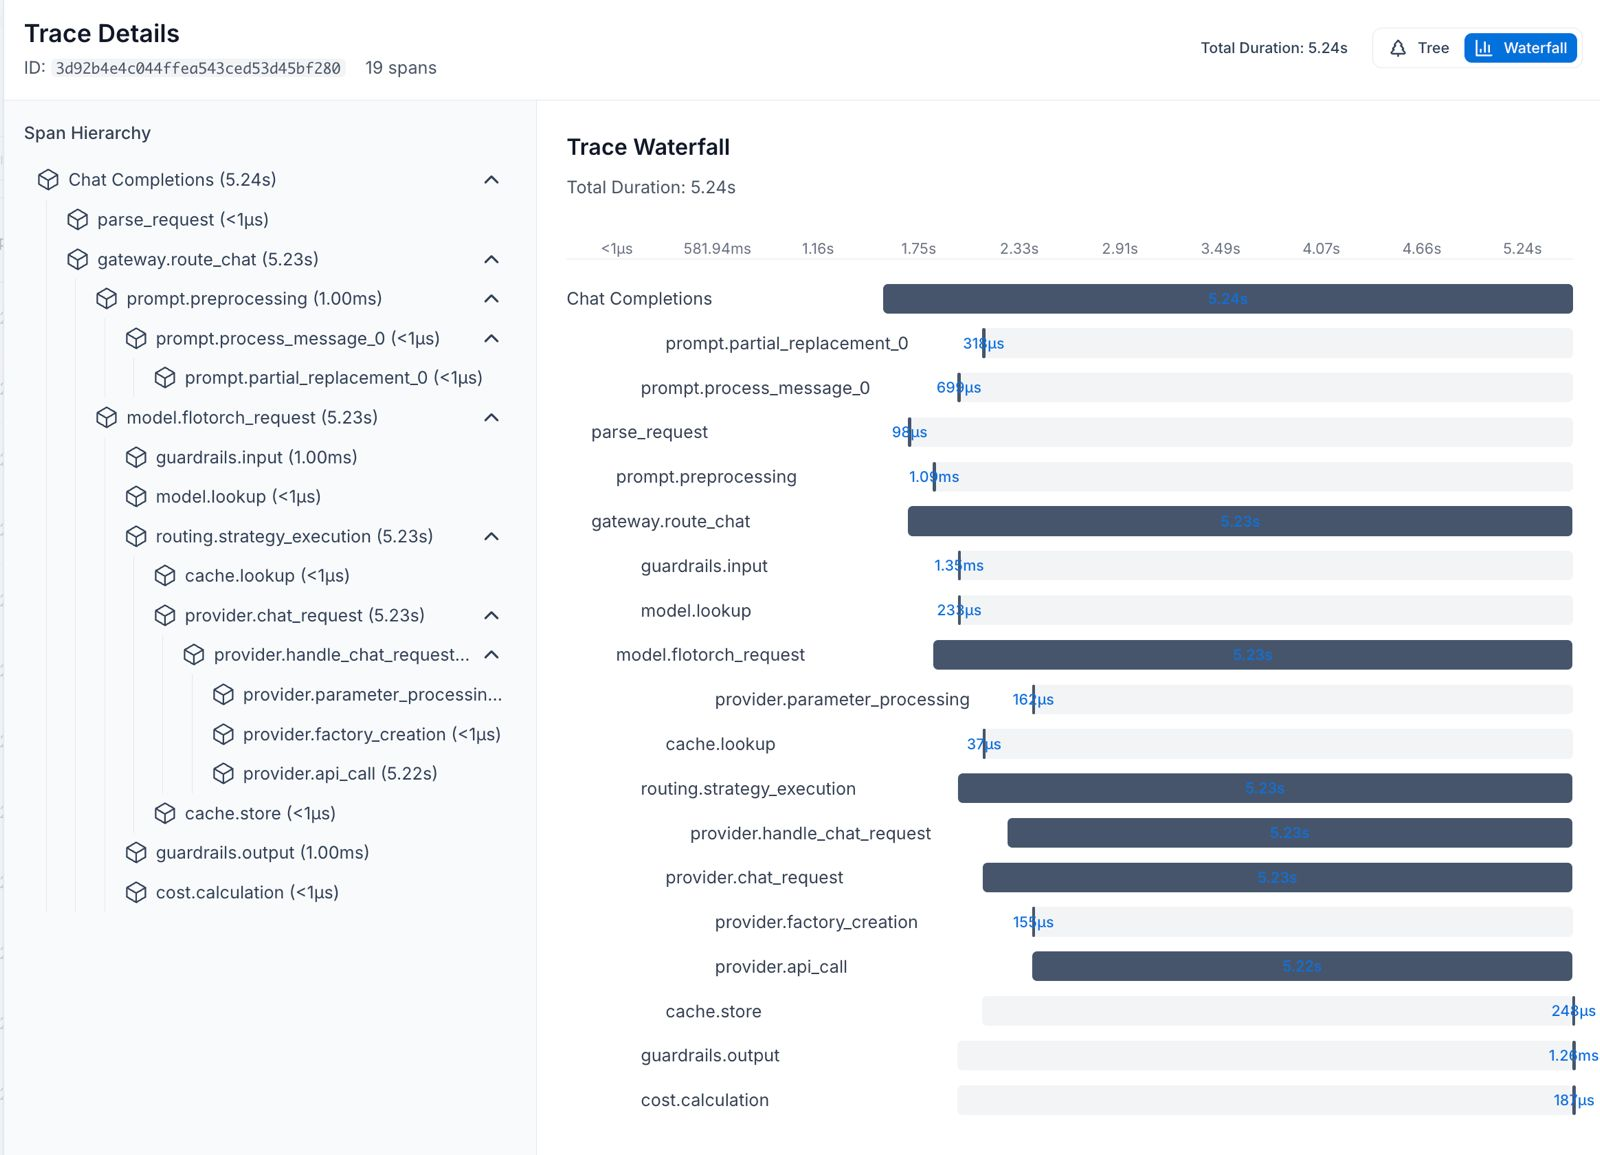

---

## 🎯 What This Notebook Demonstrates:

### **RAG Pipeline with Monitoring using FloTorch:**
1. **PDF Processing**: Extracts and processes text from uploaded PDFs
2. **Vector Search**: Uses FAISS for semantic similarity search
3. **Monitored LLM Calls**: All API calls go through Flotorch gateway
4. **Usage Tracking**: Real-time token counting and cost monitoring
5. **Performance Analytics**: Dashboard access for detailed metrics

### **Key Advantages of Flotorch Integration:**
- **🔍 Transparency**: See exactly how many tokens each RAG query uses
- **💰 Cost Control**: Track spending across different document types
- **📊 Analytics**: Understand usage patterns in your RAG system
- **🛡️ Reliability**: Gateway provides error handling and retry logic
- **⚡ Performance**: Monitor response times and optimize accordingly

### **Production Benefits:**
- Scale RAG systems with confidence knowing your costs
- Debug issues with detailed API call logs
- Optimize prompts based on token usage analytics
- Set up alerts for unusual usage patterns
- Compare performance across different models

---

*This notebook shows how Flotorch transforms basic RAG implementations into production-ready, monitored systems with complete visibility into LLM usage and costs.*